In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf

# Import pandas and read the charity_data.csv from the provided cloud URL.
import pandas as pd
application_df = pd.read_csv("https://static.bc-edx.com/data/dl-1-2/m21/lms/starter/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [3]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(columns=["EIN", "NAME"])

In [7]:
# Look at APPLICATION_TYPE value counts to identify and replace with "Other"
app_counts = application_df["APPLICATION_TYPE"].value_counts()
app_counts

APPLICATION_TYPE
T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: count, dtype: int64

In [9]:
# Choose a cutoff value and create a list of application types to be replaced
# use the variable name `application_types_to_replace`
rare_application_types = app_counts[app_counts < 50].keys()
uncommon_application_types = app_counts[(app_counts >= 50) & (app_counts < 1000)].keys()

# Replace in dataframe
for app in rare_application_types:
    application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(app,"Rare")
for app in uncommon_application_types:
    application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(app,"Uncommon")

# Check to make sure replacement was successful
application_df['APPLICATION_TYPE'].value_counts()

APPLICATION_TYPE
T3          27037
Uncommon     2212
T4           1542
T6           1216
T5           1173
T19          1065
Rare           54
Name: count, dtype: int64

In [11]:
# Look at CLASSIFICATION value counts to identify and replace with "Other"
class_counts = application_df["CLASSIFICATION"].value_counts()
class_counts

CLASSIFICATION
C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C4120        1
C8210        1
C2561        1
C4500        1
C2150        1
Name: count, Length: 71, dtype: int64

In [13]:
# Choose a cutoff value and create a list of classifications to be replaced
# use the variable name `classifications_to_replace`
very_rare_classifications = class_counts[class_counts <= 20].keys()
rare_classifications = class_counts[(class_counts > 20) & (class_counts <= 75)].keys()
uncommon_classifications = class_counts[(class_counts > 75) & (class_counts <= 500)].keys()

# Replace in dataframe
for cls in very_rare_classifications:
    application_df['CLASSIFICATION'] = application_df['CLASSIFICATION'].replace(cls,"Very Rare")
for cls in rare_classifications:
    application_df['CLASSIFICATION'] = application_df['CLASSIFICATION'].replace(cls,"Rare")
for cls in uncommon_classifications:
    application_df['CLASSIFICATION'] = application_df['CLASSIFICATION'].replace(cls,"Uncommon")

# Check to make sure replacement was successful
application_df['CLASSIFICATION'].value_counts()

CLASSIFICATION
C1000        17326
C2000         6074
C1200         4837
C3000         1918
C2100         1883
Uncommon       910
C7000          777
Rare           347
Very Rare      227
Name: count, dtype: int64

In [15]:
# Since the monetary values are inherently ordered in their magnitude, and get_dummies can't capture that, I'm going to map them onto ordered integers instead
income_mapping = {
    '0': 0,
    '1-9999': 1,
    '10000-24999': 2,
    '25000-99999': 3,
    '100000-499999': 4,
    '1M-5M': 5,
    '5M-10M': 6,
    '10M-50M': 7,
    '50M+': 8
}
application_df["INCOME_ENCODED"] = application_df["INCOME_AMT"].map(income_mapping)
application_df = application_df.drop("INCOME_AMT", axis=1)
application_df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL,INCOME_ENCODED
0,Uncommon,Independent,C1000,ProductDev,Association,1,N,5000,1,0
1,T3,Independent,C2000,Preservation,Co-operative,1,N,108590,1,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,N,5000,0,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,N,6692,1,2
4,T3,Independent,C1000,Heathcare,Trust,1,N,142590,1,4


In [17]:
# Convert categorical data to numeric with `pd.get_dummies`
app_dummies = pd.get_dummies(application_df, columns=["APPLICATION_TYPE", "AFFILIATION", "CLASSIFICATION", "USE_CASE", "ORGANIZATION", "SPECIAL_CONSIDERATIONS"])

In [121]:
# Split our preprocessed data into our features and target arrays
y = app_dummies["IS_SUCCESSFUL"].values
X = app_dummies.drop(["IS_SUCCESSFUL"], axis=1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [123]:
len(X_train[0])

36

In [131]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 128
hidden_nodes_layer2 = 64
hidden_nodes_layer3 = 32
hidden_nodes_layer4 = 16
hidden_nodes_layer5 = 8

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)
# Second hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu")
)
# LeakyReLU layer
nn.add(
    tf.keras.layers.LeakyReLU(alpha=0.01)
)
# Third hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu")
)
# LeakyReLU layer
nn.add(
    tf.keras.layers.LeakyReLU(alpha=0.01)
)
# Fourth hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer4, activation="relu")
)
# Fifth hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer5, activation="relu")
)
# Output layer
nn.add(
    tf.keras.layers.Dense(units=1, activation="sigmoid")
)
# Check the structure of the model
nn.summary()
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

C:\Users\sicke\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\sicke\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_41 (Dense)                     │ (None, 128)                 │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,745 (61.50 KB)

 Trainable params: 15,745 (61.50 KB)

 Non-trainable params: 0 (0.00 B)

In [133]:
# Compile the model
nn.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)

In [135]:
# Train the model
history = nn.fit(X_train_scaled, y_train, epochs=15)

Epoch 1/15
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6892 - loss: 0.6022
Epoch 2/15
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7297 - loss: 0.5567
Epoch 3/15
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7286 - loss: 0.5574
Epoch 4/15
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7340 - loss: 0.5511
Epoch 5/15
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7335 - loss: 0.5514   
Epoch 6/15
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7356 - loss: 0.5493
Epoch 7/15
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7293 - loss: 0.5534
Epoch 8/15
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7293 - loss: 0.5506
Epoch 9/15
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7306 - loss: 0.5504 
Epoch 10/15
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7350 - loss: 0.5496
Epoch 11/15
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7328 - loss: 0.5484
Epoch 12/15
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/

In [15]:
history.history

{'accuracy': [0.713769257068634,
  0.7276084423065186,
  0.7299020290374756,
  0.7301352620124817,
  0.7302130460739136,
  0.7307572960853577,
  0.7323899865150452,
  0.7321956157684326,
  0.7326620817184448,
  0.7325843572616577,
  0.7334784865379333,
  0.7325843572616577,
  0.7332841157913208,
  0.7327010035514832,
  0.7335562109947205,
  0.7327010035514832,
  0.7331286072731018,
  0.7348779439926147,
  0.7331286072731018,
  0.735344409942627,
  0.7354610562324524,
  0.7347224354743958,
  0.7348779439926147,
  0.7356554269790649,
  0.733906090259552,
  0.7346447110176086,
  0.7341781854629517,
  0.7351111769676208,
  0.7355387806892395,
  0.7353055477142334,
  0.7359275221824646,
  0.7356165647506714,
  0.7354610562324524,
  0.7349945306777954,
  0.735888659954071,
  0.7366272807121277,
  0.735733151435852,
  0.7369382381439209,
  0.7360053062438965,
  0.7352278232574463,
  0.7368605136871338,
  0.7377546429634094,
  0.7367438673973083,
  0.7364329099655151,
  0.7366272807121277,
  0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


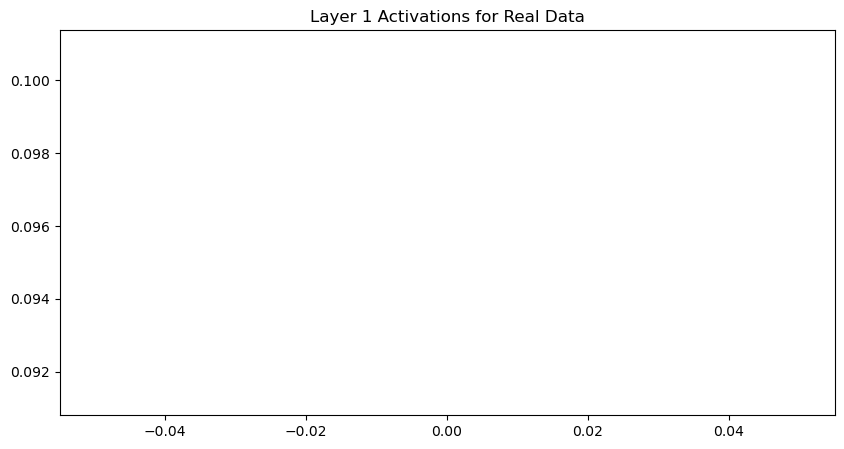

In [141]:
activations = nn.predict(X_train_scaled[0:1])
import matplotlib.pyplot as plt

# Iterate through activations and plot them
for i, activation in enumerate(activations):
    plt.figure(figsize=(10, 5))
    plt.title(f"Layer {i + 1} Activations for Real Data")
    plt.plot(activation.flatten())  # Flatten for dense layers
    plt.show()


In [143]:
for i, activation in enumerate(activations):
    print(f"Activation for Layer {i+1}:")
    print(activation)
    print("\n---\n")


Activation for Layer 1:
[0.09608918]

---



In [145]:
for layer in nn.layers:
    print(layer.name, layer.get_weights())


dense_41 [array([[ 0.05917278, -0.10753089,  0.02350155, ..., -0.09562895,
        -0.10418785,  0.12741818],
       [ 0.09115471, -0.07775722,  0.03131948, ...,  0.02511736,
        -0.34316587, -0.46185875],
       [ 0.4221582 ,  0.18197912, -0.49352938, ..., -0.41704714,
        -0.12321699, -0.27332535],
       ...,
       [-0.04275896,  0.1943102 ,  0.15178664, ...,  0.01485528,
         0.26723537, -0.26205286],
       [-0.06544553, -0.20080562,  0.00628967, ...,  0.20989724,
         0.04273329,  0.04859453],
       [ 0.04033335,  0.02274345, -0.04026432, ..., -0.0390648 ,
         0.05113962, -0.18855406]], dtype=float32), array([-0.12045775, -0.14729139, -0.10635616, -0.21844728, -0.07455532,
       -0.04693034, -0.05180829, -0.10884597, -0.05417358,  0.11449039,
       -0.13081743, -0.04485305, -0.03572599, -0.08737863, -0.07821851,
       -0.04616098, -0.12125318, -0.09051169, -0.0579824 ,  0.08676648,
       -0.18828678,  0.04439928, -0.14823069,  0.01018888, -0.03161906,
 